In [1]:
%load_ext lab_black

In [56]:
from gpjax.gps import Prior
from gpjax import RBF, Gaussian
import jax.numpy as jnp
import jax.random as jr
import objax
import matplotlib.pyplot as plt
from tensorflow_probability.substrates.jax import distributions as tfd
from scipy.stats import norm

key = jr.PRNGKey(123)

In [82]:
forrester = lambda x: jnp.square(6 * x - 2) * jnp.sin(12 * x - 4)
nits = 20

x = jr.uniform(key, shape=(10, 1))
y = forrester(design_point)

query_points = jnp.linspace(0.0, 1.0, 1000).reshape(-1, 1)

for i in range(nits):
    # Place prior on f
    posterior = Prior(RBF()) * Gaussian()

    # Compute the posterior of f, conditional upon our previously observed points
    opt = objax.optimizer.SGD(posterior.vars())
    gv = objax.GradValues(posterior.neg_mll, posterior.vars())

    def train_op(x, label):
        g, v = gv(x, label)
        opt(0.01, g)
        return v

    train_op = objax.Jit(train_op, gv.vars() + opt.vars())
    nits = 100
    loss = [train_op(initial_obs[0], initial_obs[1])[0].item() for _ in range(nits)]

    # Query the GP across the function's domain
    mu, cov = posterior.predict(query_points, x, y)
    sigma = jnp.sqrt(jnp.diag(cov))

    # Maximise
    delta = mu.ravel() - y[-1]
    z = delta / sigma
    unit_norm = norm()
    res = delta * unit_norm.cdf(z) + sigma * unit_norm.pdf(z)

    best_idx = jnp.argmin(res)
    new_x = query_points[best_idx, :]
    new_y = forrester(new_x)
    x = jnp.vstack((x, new_x))
    y = jnp.vstack((y, new_y))

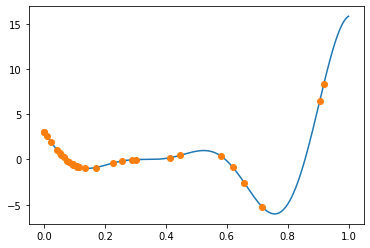

In [83]:
plt.plot(query_points, forrester(query_points))
plt.plot(x, y, "o")

In [86]:
posterior = Prior(RBF()) * Gaussian()

# Compute the posterior of f, conditional upon our previously observed points
opt = objax.optimizer.SGD(posterior.vars())
gv = objax.GradValues(posterior.neg_mll, posterior.vars())


def train_op(x, label):
    g, v = gv(x, label)
    opt(0.01, g)
    return v


train_op = objax.Jit(train_op, gv.vars() + opt.vars())
nits = 100
loss = [train_op(initial_obs[0], initial_obs[1])[0].item() for _ in range(nits)]

# Query the GP across the function's domain
mu, cov = posterior.predict(query_points, x, y)
sigma = jnp.sqrt(jnp.diag(cov))

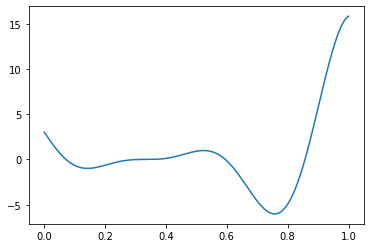

In [3]:
forrester = lambda x: jnp.square(6 * x - 2) * jnp.sin(12 * x - 4)
x = jnp.linspace(0.0, 1.0, 200).reshape(-1, 1)
y = forrester(x)
plt.plot(x, y)

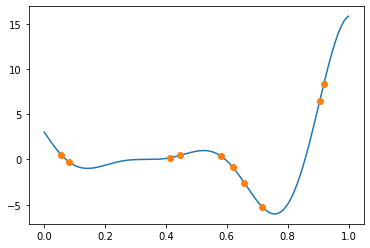

In [31]:
key = jr.PRNGKey(123)
design_point = jr.uniform(key, shape=(10, 1))
initial_obs = (design_point, forrester(design_point))
plt.plot(x, y)
plt.plot(initial_obs[0], initial_obs[1], "o")

In [32]:
initial_obs[1].shape

(10, 1)

In [33]:
posterior = Prior(RBF()) * Gaussian()

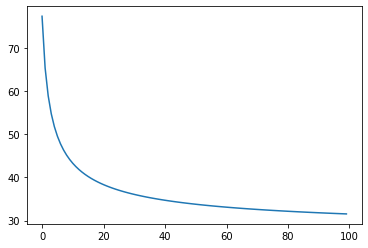

In [34]:
opt = objax.optimizer.SGD(posterior.vars())
gv = objax.GradValues(posterior.neg_mll, posterior.vars())


def train_op(x, label):
    g, v = gv(x, label)
    opt(0.01, g)
    return v


train_op = objax.Jit(train_op, gv.vars() + opt.vars())

nits = 100
loss = [train_op(initial_obs[0], initial_obs[1])[0].item() for _ in range(nits)]
plt.plot(loss)

In [35]:
mu, cov = posterior.predict(x, initial_obs[0], initial_obs[1])
sigma = jnp.diag(cov)

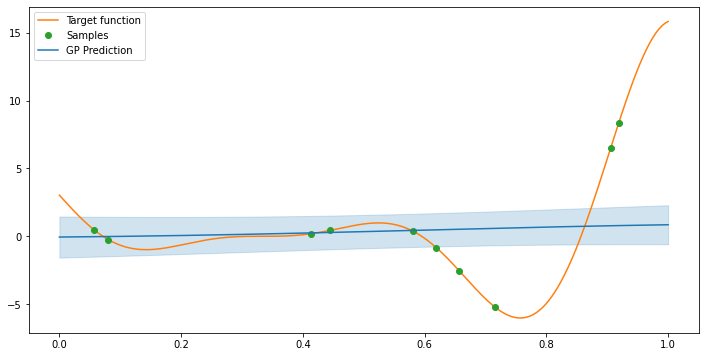

In [42]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(x, y, color="tab:orange", label="Target function")
ax.plot(initial_obs[0], initial_obs[1], "o", color="tab:green", label="Samples")
ax.plot(x, mu, label="GP Prediction", color="tab:blue")
ax.fill_between(
    x.ravel(),
    mu.ravel() - 1.96 * jnp.sqrt(sigma.ravel()),
    mu.ravel() + 1.96 * jnp.sqrt(sigma.ravel()),
    alpha=0.2,
    color="tab:blue",
)
ax.legend(loc="best")

In [45]:
eta = jnp.min(mu)
mu, cov = posterior.predict(x, initial_obs[0], initial_obs[1])

sigma = jnp.diag(cov)
rv = tfd.Normal(mu, sigma)
ei = (eta - mean) * normal.cdf(eta) + variance * normal.prob(eta)